**NOTEBOOK 2: PLANAR VS TUBULAR MECHANICAL TESTING AND MODELLING**

Mobina Izadpanah (mobina.izadpanah@maastrichtuniversity.nl) and Alessandro Giudici (a.giudici@maastrichtuniversity.nl)

Welcome to Part 2!

As our first task, we’ll fit the HGO model to the planar biaxial experimental data ourselves. The dataset comes from a coarotid artery sample of a one-year-old sheep and was collected in our Maastricht lab by our colleague Cindy van Loo.

As usual, let’s define the HGO formulations:

In [14]:
import numpy as np
import matplotlib.pyplot as plt

Pa2mmHg = 1 / 133.32 # conversion of [Pa] to [mmHg]

def hgo_stress(lambda_t, lambda_z, c , k1, k2, alpha):

    """
    HGO circumferential (t), axial (z) and radial (r) stress function

    Parameters:
    ----------
    lambda_t: circumferential stretch (dimensionless)
    lambda_z: axial stretch (dimensionless)
    c: neo-Hookean parameter (Pa)
    k1: stress-like parameter for fibres (Pa)
    k2: nonlinearity parameter (dimensionless)
    alpha: fibre angle (radian)

    return:
    ----------
    sigmatt: circumferential Cauchy stress (Pa)
    sigmazz: axial Cauchy stress (Pa)
    sigmarr: radial Cauchy stress (Pa)

    """
    # Defining stretches
    lambda_t = np.asarray(lambda_t, dtype=np.float64)
    lambda_z = np.asarray(lambda_z, dtype=np.float64)

    # Fibre angles
    cos_a = np.cos(alpha)
    sin_a = np.sin(alpha)

    # Fibre invariant
    I4 = lambda_t**2 * cos_a**2 + lambda_z**2 * sin_a**2

    # Circumferential extra Cauchy stress
    # ECM (isotropic) contribution
    sigmatt_matrix = c * lambda_t**2

    # Collagen (fiber) contribution
    sigmatt_fibre = (2* 2.0 * k1 * lambda_t**2 * cos_a**2 * (I4 - 1)
                     * np.exp(k2 * (I4-1)**2))

    sigmatt_total = sigmatt_matrix + sigmatt_fibre

    # Axial extra Cauchy stress
    # Matrix (isotropic) contribution
    sigmazz_matrix = c * lambda_z**2

    # Collagen (fiber) contribution
    sigmazz_fibre = (2 * 2 * k1 * lambda_z**2 * sin_a**2 * (I4 - 1)
                     * np.exp(k2 * (I4-1)**2))

    sigmazz_total = sigmazz_matrix + sigmazz_fibre

    # Radial extra Cauchy stress
    # Matrix (isotropic) contribution
    sigmarr_matrix = c * lambda_t**(-2) * lambda_z**(-2)

    # Collagen (fiber) contribution
    sigmarr_fibre = 0

    sigmarr_total = sigmarr_matrix + sigmarr_fibre

    return {"sigmatt_total": sigmatt_total,
             "sigmatt_matrix":sigmatt_matrix,
             "sigmatt_fibre":sigmatt_fibre,
             "sigmazz_total":sigmazz_total,
             "sigmazz_matrix":sigmazz_matrix,
             "sigmazz_fibre":sigmazz_fibre,
             "sigmarr_total":sigmarr_total,
             "sigmarr_matrix":sigmarr_matrix,
             "sigmarr_fibre": sigmarr_fibre}


Now it’s time to add the experimental data stored in the Excel files. Please make sure that the excel files are uploaded in the Google Colab environment; in the icon menu on the left side of the screen, click on the folder icon and then on "upload" to select the files to be uploaded (i.e., "biaxial_all.xlsx" and "dynamX.xlsx"). Once this is done, run the code below to upload the Excel sheets for planar biaxial and pressure–diameter tests.

In [15]:
import numpy as np
import pandas as pd
import os
import glob
from openpyxl import load_workbook

# Let's make sure that the files are uploaded in the colab environment
base_path = "/content"
biaxial_path = os.path.join(base_path, "biaxial_all.xlsx")
dynamax_path = os.path.join(base_path, "dynamX_d.xlsx")

# Load dynamax pressure-diameter data
dynamax_xls = pd.ExcelFile(dynamax_path)




# Load CellScale biaxial
biaxial_xls = pd.ExcelFile(biaxial_path)



# Store sheets or extracted data
biaxial_data = {}
dynamax_pd_data = {}
dynamax_fl_data = {}


Let’s revisit the planar biaxial tests we introduced in the previous notebook. Now, we’ll fit the HGO model to the biaxial experimental data.

In [16]:
# Fitting the HGO model to planar biaxial data

from scipy.optimize import least_squares

# Sample dimensions
thickness_initial = 0.9403e-3 # initial thickness (m)
sample_length_t = 10.7e-3 # sample dimension (m)
sample_length_z = 10.7e-3 # sample dimension (m)
area_t_initial = thickness_initial * sample_length_z
area_z_initial = thickness_initial * sample_length_t

# Reading the Excel datasheets and calculating the Cauchy stresses

# NOTE: As shown in notebook1, we use theta for the circumferential direction and z for the axial direction.
# However, in the experimental datasets, these directions are labeled as x and y, respectively.
# As a result, theta/z and x/y are used interchangeably in some parts of the code.

for sheet in biaxial_xls.sheet_names:
    data = pd.read_excel(biaxial_path, sheet_name = sheet)
    lambda_t = np.array(data["Stretch_x"], dtype=float)
    lambda_z = np.array(data["Stretch_y"], dtype=float)
    force_t = np.array(data["Force_x"], dtype=float)
    sigma_tt = force_t/(area_t_initial)*lambda_t
    force_z = np.array(data["Force_y"], dtype=float)
    sigma_zz = force_z/(area_z_initial)*lambda_z
    biaxial_data[sheet] = {"force_x": force_t, "force_y": force_z, "cauchy_x": sigma_tt,
                           "cauchy_y": sigma_zz, "stretch_x": lambda_t, "stretch_y": lambda_z}



# Defining the residual function for fitting

#scaling parameters
p_scale = np.array([100e3, 100e3, 50, np.deg2rad(90)])

def residuals(q, biaxial_data):
    p = q * p_scale
    c, k1, k2, alpha = p
    r_list = []

    for name, var in biaxial_data.items():
        lambda_t_meas = np.asarray(var["stretch_x"], dtype=float).ravel()
        lambda_z_meas = np.asarray(var["stretch_y"], dtype=float).ravel()
        sigma_tt_meas = np.asarray(var["cauchy_x"], dtype=float).ravel()
        sigma_zz_meas = np.asarray(var["cauchy_y"], dtype=float).ravel()

        stresses = hgo_stress(lambda_t_meas, lambda_z_meas, c, k1, k2, alpha)
        sigma_tt_mod = stresses["sigmatt_total"] - stresses["sigmarr_total"] # also accounting for the Lagrange multiplier
        sigma_zz_mod = stresses["sigmazz_total"] - stresses["sigmarr_total"] # also accounting for the Lagrange multiplier

        # append residuals (all tests)
        sigma_tt_scale = np.mean(sigma_tt_meas)
        sigma_zz_scale = np.mean(sigma_zz_meas)
        r_list.append((sigma_tt_mod - sigma_tt_meas)/sigma_tt_scale)
        r_list.append((sigma_zz_mod - sigma_zz_meas)/sigma_zz_scale)

    return np.concatenate(r_list)
eps = 1e-6
# initial guess for [c, k1, k2]
p0 = np.array([1e3, 1e3, 0.5, np.deg2rad(45)])/p_scale
# lower boundary
lb = np.array([eps, eps, eps, eps])/p_scale
# upper boundary
ub = np.array([100e3, 100e3, 50, np.deg2rad(90)])/p_scale

result_hgo_scaled = least_squares( residuals, x0 = p0,
                                  bounds=(lb, ub), args = (biaxial_data,))
result_hgo = result_hgo_scaled.x * p_scale

print(f"Best-fit HGO parameters:")
print(f"c = {result_hgo[0]/1000:.2f} kPa")
print(f"k₁ = {result_hgo[1]/1000:.2f} kPa")
print(f"k₂ = {result_hgo[2]:.2f}")
print(f"α = {np.rad2deg(result_hgo[3]):.2f} deg")


Best-fit HGO parameters:
c = 15.95 kPa
k₁ = 2.10 kPa
k₂ = 0.80
α = 36.05 deg


Listed above are the best fit HGO parameters. Let's see the quality of the fit!

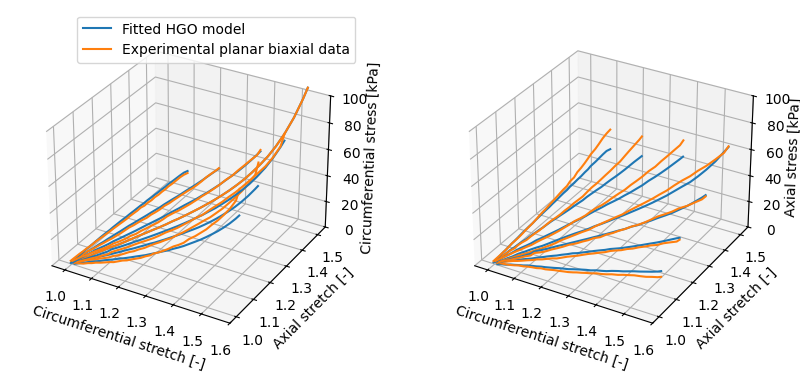

In [17]:
# plotting the planar biaxial experimental data vs the fitted HGO model

fig, (ax1, ax2) = plt.subplots(
    1,2,
    subplot_kw={"projection": "3d"},
    figsize=(10, 12),
    #constrained_layout=True
)
first1 = True
first2 = True

for name, var in biaxial_data.items():
    lambda_t_meas = np.asarray(var["stretch_x"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_y"], dtype=float).ravel()
    sigma_tt_meas = np.asarray(var["cauchy_x"], dtype=float).ravel()
    sigma_zz_meas = np.asarray(var["cauchy_y"], dtype=float).ravel()
    stresses = hgo_stress(lambda_t_meas, lambda_z_meas,
                          result_hgo[0], result_hgo[1], result_hgo[2], result_hgo[3])
    sigma_tt_mod = stresses["sigmatt_total"] - stresses["sigmarr_total"]
    sigma_zz_mod = stresses["sigmazz_total"] - stresses["sigmarr_total"]

    if first1:
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_mod/1000,
                color='C0', label='Fitted HGO model')
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_mod/1000,
                color='C1', label='Experimental planar biaxial data')
        first1 = False
    else:
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_mod/1000, color='C0')
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_meas/1000, color='C1')

    if first2:
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_mod/1000,
                color='C0')
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_meas/1000,
                color='C1')
        first2 = False
    else:
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_mod/1000, color='C0')
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_meas/1000, color='C1')

ax1.set_xlabel('Circumferential stretch [-]')
ax1.set_ylabel('Axial stretch [-]')
ax1.set_zlabel('Circumferential stress [kPa]',labelpad=0.1)
ax1.set_box_aspect(None, zoom=0.9)
ax1.legend()
ax1.set_zlim([0,100])
ax2.set_xlabel('Circumferential stretch [-]')
ax2.set_ylabel('Axial stretch [-]')
ax2.set_zlabel('Axial stress [kPa]',labelpad=0.1)
ax2.set_box_aspect(None, zoom=0.9)
ax2.set_zlim([0,100])

plt.show()


Now, let’s compare how well the same HGO constitutive model captures tube behaviour (i.e., the biomechanical response of the artery to physiologically inspired loading).

Beyond planar biaxial testing, several experimental approaches are used to study arterial wall mechanics. For example, pressure–diameter data can be obtained directly using an experimental setup called DynamX. In this system, arteries are mounted in their native tubular form and simultaneously pressurized and stretched axially, allowing simultaneous measurement of pressure–diameter and force–length relationships.

<div style="text-align:center;">
  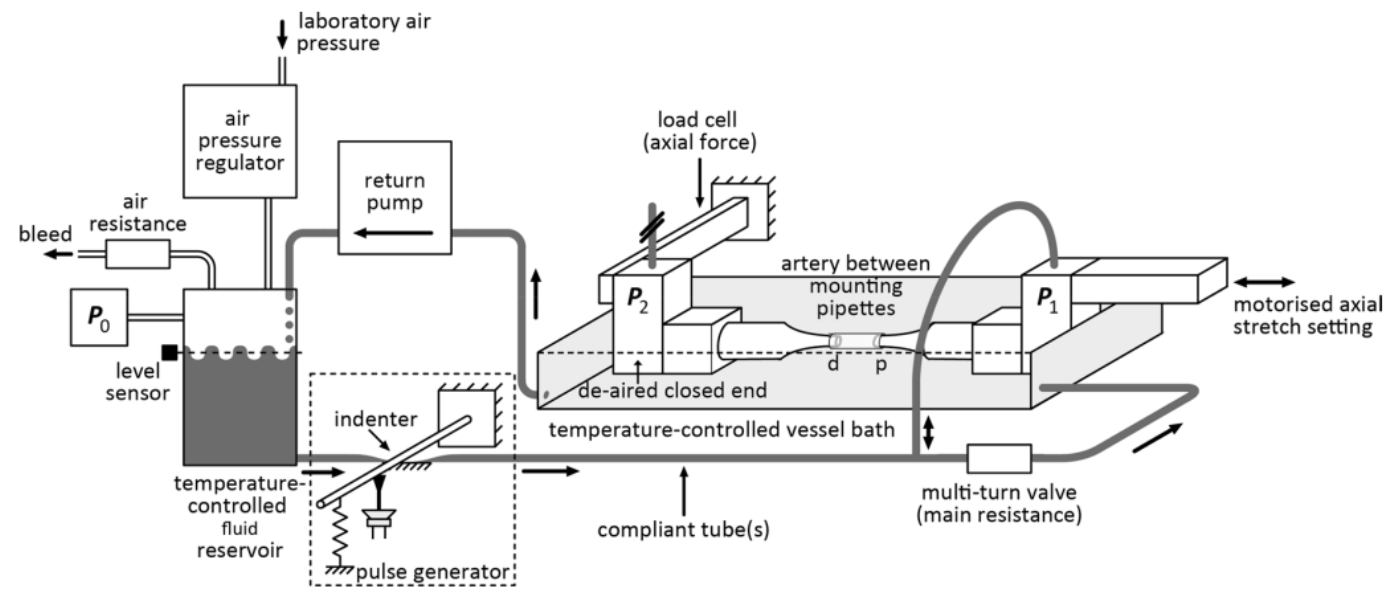
    <div style="font-size:90%; margin-top:6px;">
    <b>Figure 2.</b> DynamX set-up overview [1].
  </div>
</div>

First, we upload the DynamX dataset and organize it for analysis. Note that these data were obtained from the same carotid artery of the same one-year-old sheep described above for planar biaxial testing.

In [18]:
# Simulating the arterial tube behaviour

# Experimental pressurization of the artery
D_o = 5.923e-3 # unloaded outer diameter (m)
H = 0.999e-3 # unloaded thickness (m)
length_initial = 24.3e-3 # initial length (m)
D_m = D_o - H # unloaded mid-wall diameter (m)

# Reading the Excel datasheets for Dynamax (pressure-diameter data)
for sheet in dynamax_xls.sheet_names:
    data_p = pd.read_excel(dynamax_path, sheet_name = sheet)
    p_dyn = np.array(data_p["Pressure mmhg"], dtype=float) # Pressure in mmHg
    d_o_dyn = np.array(data_p["outer diameter um"]/1000000, dtype=float) # outer diameter in meter
    d_i_dyn = np.array(data_p["inner diameter um"]/1000000, dtype=float) # inner diameter in meter
    red_axial_force_dyn = np.array(data_p["transducer axial force g"]*9.81/1000, dtype=float) # outer diameter in meter
    lambda_z_dyn = np.array(data_p["axial Stretch"], dtype=float) # inner diameter in meter


    lambda_t = (d_o_dyn + np.sqrt(d_o_dyn**2 - 4*(D_o-H)*H/lambda_z_dyn))/(2*(D_o-H))

    if "pd" in sheet.lower():
        dynamax_pd_data[sheet] = {
            "pressure": p_dyn,
            "outer_diam": d_o_dyn,
            "inner_diam": d_i_dyn,
            "force": red_axial_force_dyn,
            "stretch_t": lambda_t,
            "stretch_z": lambda_z_dyn
        }

    elif "fl" in sheet.lower():
        dynamax_fl_data[sheet] = {
            "pressure": p_dyn,
            "outer_diam": d_o_dyn,
            "inner_diam": d_i_dyn,
            "force": red_axial_force_dyn,
            "stretch_t": lambda_t,
            "stretch_z": lambda_z_dyn
        }


Next, let’s fit our HGO model to the DynamX data and see how well it captures the tubular response.

In [19]:
# Fitting HGO to DynamX

#scaling parameters
param_scale = np.array([100e3, 100e3, 50, np.deg2rad(90)])

def pressure_residuals_hgo(q, dynamax_pd_data, dynamax_fl_data):
    hgo_params = q * param_scale
    r_list = []

    for name, var in dynamax_pd_data.items():

        p_meas = np.asarray(var["pressure"], dtype=float).ravel()
        d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
        d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
        lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
        f_meas = np.asarray(var["force"], dtype=float).ravel()
        lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

        stresses = hgo_stress(lambda_t, lambda_z_meas, hgo_params[0] , hgo_params[1],
                              hgo_params[2], hgo_params[3])
        sigma_tt_mod = stresses["sigmatt_total"]
        sigma_zz_mod = stresses["sigmazz_total"]
        sigma_rr_mod = stresses["sigmarr_total"]

        h = H / (lambda_t * lambda_z_meas) # loaded wall thickness
        r_m = D_m/2 * lambda_t # loaded mid-wall radius

        p_model_hgo = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
        p_scale = np.mean(p_meas)

        f_mod_hgo = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)
        f_scale = np.mean(f_meas)

        r_list.append((p_model_hgo - p_meas)/p_scale)
        r_list.append((f_mod_hgo - f_meas)/f_scale)

    for name, var in dynamax_fl_data.items():

        p_meas = np.asarray(var["pressure"], dtype=float).ravel()
        d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
        d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
        lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
        f_meas = np.asarray(var["force"], dtype=float).ravel()
        lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

        stresses = hgo_stress(lambda_t, lambda_z_meas, hgo_params[0] , hgo_params[1],
                              hgo_params[2], hgo_params[3])
        sigma_tt_mod = stresses["sigmatt_total"]
        sigma_zz_mod = stresses["sigmazz_total"]
        sigma_rr_mod = stresses["sigmarr_total"]

        h = H / (lambda_t * lambda_z_meas) # loaded wall thickness
        r_m = D_m/2 * lambda_t # loaded mid-wall radius

        p_model_hgo = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
        p_scale = np.mean(p_meas)

        f_mod_hgo = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)
        f_scale = np.mean(f_meas)

        r_list.append((p_model_hgo - p_meas)/p_scale)
        r_list.append((f_mod_hgo - f_meas)/f_scale)

    return np.concatenate(r_list)


eps = 1e-6
# initial guess for [c, k1, k2, alpha]
p0 = np.array([1e3, 1e3, 0.5, np.deg2rad(40)])/param_scale
# lower boundary
lb = np.array([eps, eps, eps, eps])/param_scale
# upper boundary
ub = np.array([100e3, 100e3, 50, np.deg2rad(90)])/param_scale

result_hgo_dyn_scaled = least_squares( pressure_residuals_hgo, x0 = p0, bounds=(lb, ub), args = (dynamax_pd_data, dynamax_fl_data))
result_hgo_dyn= result_hgo_dyn_scaled.x * param_scale

print(f"Best-fit HGO parameters:")
print(f"c  = {result_hgo_dyn[0]/1000:6.2f} kPa")
print(f"k₁ = {result_hgo_dyn[1]/1000:6.2f} kPa")
print(f"k₂ = {result_hgo_dyn[2]:6.2f}")
print(f"α  = {np.rad2deg(result_hgo_dyn[3]):6.2f}°")



Best-fit HGO parameters:
c  =  12.13 kPa
k₁ =   0.55 kPa
k₂ =   0.92
α  =  34.15°


Let's check the fit quality!

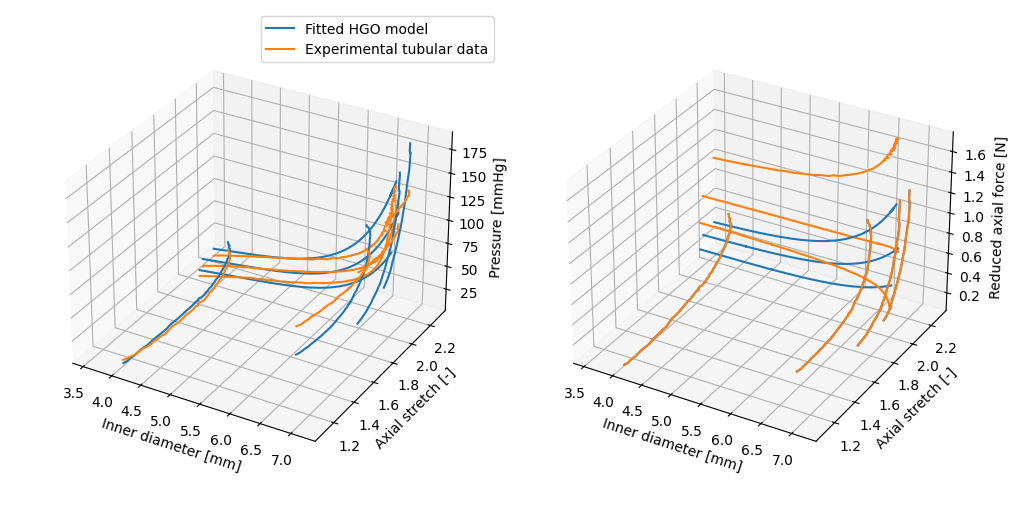

In [20]:
# plotting the fit vs experimental curves
fig, (ax1, ax2) = plt.subplots(
    1,2,
    subplot_kw={"projection": "3d"},
    figsize=(10, 10),
    constrained_layout=True
)

first = True
first2 = True

for name, var in dynamax_pd_data.items():

    p_meas = np.asarray(var["pressure"], dtype=float).ravel()
    d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
    d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
    f_meas = np.asarray(var["force"], dtype=float).ravel()
    lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

    stresses = hgo_stress(lambda_t, lambda_z_meas, result_hgo_dyn[0] , result_hgo_dyn[1],
                          result_hgo_dyn[2], result_hgo_dyn[3])
    sigma_tt_mod = stresses["sigmatt_total"]
    sigma_zz_mod = stresses["sigmazz_total"]
    sigma_rr_mod = stresses["sigmarr_total"]

    h = H / (lambda_t * lambda_z_meas) # deformed thickness
    r_m = D_m/2 * lambda_t # deformed mid-wall radius

    p_model_hgo = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
    f_mod_hgo = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)

    if first:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo,
                color='C0', label='Fitted HGO model')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,
                color='C1', label='Experimental tubular data')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_hgo,
                color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,
                color='C1')
        first = False
    else:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo, color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas,  p_meas, color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_hgo, color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas, color='C1')

    ax1.set_zlabel('Pressure [mmHg]')
    ax1.set_ylabel('Axial stretch [-]')
    ax1.set_xlabel('Inner diameter [mm]')
    ax1.set_box_aspect(None, zoom=0.88)
    ax1.legend()

for name, var in dynamax_fl_data.items():

    p_meas = np.asarray(var["pressure"], dtype=float).ravel()
    d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
    d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
    f_meas = np.asarray(var["force"], dtype=float).ravel()
    lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

    stresses = hgo_stress(lambda_t, lambda_z_meas, result_hgo_dyn[0] , result_hgo_dyn[1],
                          result_hgo_dyn[2], result_hgo_dyn[3])
    sigma_tt_mod = stresses["sigmatt_total"]
    sigma_zz_mod = stresses["sigmazz_total"]
    sigma_rr_mod = stresses["sigmarr_total"]

    h = H / (lambda_t * lambda_z_meas) # deformed thickness
    r_m = D_m/2 * lambda_t # deformed mid-wall radius

    p_model_hgo = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
    f_mod_hgo = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)

    if first2:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo,
                color='C0', label='Fitted HGO model')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,
                color='C1', label='Experimental tubular data')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_hgo,
                color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_hgo,
                color='C1')
        first2 = False
    else:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo, color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas,  p_meas, color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas,  f_mod_hgo, color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas,  f_mod_hgo, color='C1')

    ax2.set_ylabel('Axial stretch [-]')
    ax2.set_xlabel('Inner diameter [mm]')
    ax2.set_zlabel('Reduced axial force [N]')
    ax2.set_box_aspect(None, zoom=0.88)



As you can see, the HGO model does not provide the best fit to the tubular DynamX data, suggesting that a more complex model may be needed. As you may recall, the HGO model includes only two fibre families. A natural extension of this model is to incorporate additional collagen fibre families. This leads to the so-called four-fibre family model, which includes one axial, one circumferential, and two diagonal collagen families. The model is given by:

$$
W_\text{ff} = W_\text{matrix} + W_\text{collagen}
$$
where
$$
W_\text{matrix} = c (I_1 - 3)
$$

$$
W_\text{collagen} = \sum_{i=1}^{4} \frac{k_1^i}{4k_2^i}  \exp[k_2^i (I_i-1)^2] - 1 .
$$

Let's define it as a function:

In [21]:

def ff_stress(lambda_t, lambda_z, c , k11, k21, k13, k23, k14, k24, alpha):
    """
    Four-fibre family circumferential (t) and axial (z) stress function
    Parameters:
    ----------
    lambda_t: circumferential stretch (dimensionless)
    lambda_z: axial stretch (dimensionless)
    c: neo-Hookean parameter (Pa)
    k11 = k12: stress-like parameter for fibres (Pa)
    k21 = k22: nonlinearity parameter (dimensionless)
    k13: stress-like parameter for fibres (Pa)
    k23: nonlinearity parameter (dimensionless)
    k14: stress-like parameter for fibres (Pa)
    k24: nonlinearity parameter (dimensionless)
    alpha: fibre angle (radian)


    return:
    ----------
    sigmatt: circumferential Cauchy stress (Pa)
    sigmazz: axial Cauchy stress (Pa)
    sigmarr: radial Cauchy stress (Pa)

    """
    k12 = k11
    k22 = k21
    # Defining stretches
    lambda_t = np.asarray(lambda_t, dtype=np.float64)
    lambda_z = np.asarray(lambda_z, dtype=np.float64)
    # Fibre angles
    cos_a = np.cos(alpha)
    sin_a = np.sin(alpha)
    # Fibre invariant
    I4 = lambda_t**2 * cos_a**2 + lambda_z**2 * sin_a**2

    # Circumferential Cauchy stress
    # Matrix (isotropic) contribution
    sigmatt_matrix = c * lambda_t**2
    # Collagen (fiber) contribution
    sigmatt_fibre = (
        k13 * (lambda_t**2-1) * np.exp(k23*(lambda_t**2-1)**2) * lambda_t**2
        + k11*lambda_t**2 * cos_a**2*(I4-1) * np.exp(k21*(I4-1)**2)
        + k12*lambda_t**2 * cos_a**2*(I4-1) * np.exp(k22*(I4-1)**2)
    )
    sigmatt_total = sigmatt_matrix + sigmatt_fibre

    # Axial Cauchy stress
    # Matrix (isotropic) contribution
    sigmazz_matrix = c * lambda_z**2
    # Collagen (fiber) contribution
    sigmazz_fibre = (
        k14 * (lambda_z**2-1) * np.exp(k24*(lambda_z**2-1)**2) * lambda_z**2
        + k11*lambda_z**2 * sin_a**2*(I4-1) * np.exp(k21*(I4-1)**2)
        + k12*lambda_z**2 * sin_a**2*(I4-1) * np.exp(k22*(I4-1)**2)
    )
    sigmazz_total = sigmazz_matrix + sigmazz_fibre

    # Radial extra Cauchy stress
    # Matrix (isotropic) contribution
    sigmarr_matrix = c * lambda_t**(-2) * lambda_z**(-2)
    # Collagen (fiber) contribution
    sigmarr_fibre = 0
    sigmarr_total = sigmarr_matrix + sigmarr_fibre

    return { "sigmatt_total": sigmatt_total,
             "sigmatt_matrix":sigmatt_matrix,
             "sigmatt_fibre":sigmatt_fibre,
             "sigmazz_total":sigmazz_total,
             "sigmazz_matrix":sigmazz_matrix,
             "sigmazz_fibre":sigmazz_fibre,
             "sigmarr_total":sigmarr_total,
             "sigmarr_matrix":sigmarr_matrix,
             "sigmarr_fibre": sigmarr_fibre}

Next, we fit the four-fibre family model to the tubular data.

In [22]:
#scaling parameters
param_scale_ff = np.array([100e3, 100e3, 50, 100e3, 50, 100e3, 50, np.deg2rad(90)])

def pressure_residuals_ff(q, dynamax_pd_data, dynamax_fl_data):
    ff_params = q * param_scale_ff
    r_list = []

    for name, var in dynamax_pd_data.items():

        p_meas = np.asarray(var["pressure"], dtype=float).ravel()
        d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
        d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
        lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
        f_meas = np.asarray(var["force"], dtype=float).ravel()
        lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()
        length_z = length_initial*lambda_z_meas


        stresses = ff_stress(lambda_t, lambda_z_meas,
                         ff_params[0], ff_params[1], ff_params[2],ff_params[3],
                         ff_params[4],ff_params[5],ff_params[6],ff_params[7])
        sigma_tt_mod = stresses["sigmatt_total"]
        sigma_zz_mod = stresses["sigmazz_total"]
        sigma_rr_mod = stresses["sigmarr_total"]

        h = H / (lambda_t * lambda_z_meas) # deformed wall thickness
        r_m = D_m/2 * lambda_t # deformed mid-wall radius

        p_model_ff = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
        p_scale = np.mean(p_meas)

        f_mod_ff = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)
        f_scale = np.mean(f_meas)

        r_list.append((p_model_ff - p_meas)/p_scale)
        r_list.append((f_mod_ff - f_meas)/f_scale)

    for name, var in dynamax_fl_data.items():

        p_meas = np.asarray(var["pressure"], dtype=float).ravel()
        d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
        d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
        lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
        f_meas = np.asarray(var["force"], dtype=float).ravel()
        lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

        stresses = ff_stress(lambda_t, lambda_z_meas,
                         ff_params[0], ff_params[1], ff_params[2],ff_params[3],
                         ff_params[4],ff_params[5],ff_params[6],ff_params[7])
        sigma_tt_mod = stresses["sigmatt_total"]
        sigma_zz_mod = stresses["sigmazz_total"]
        sigma_rr_mod = stresses["sigmarr_total"]

        p_model_ff = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
        p_scale = np.mean(p_meas)

        f_mod_ff = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)
        f_scale = np.mean(f_meas)

        r_list.append((p_model_ff - p_meas)/p_scale)
        r_list.append((f_mod_ff - f_meas)/f_scale)

    return np.concatenate(r_list)

eps = 1e-6
# initial guess for [c , k11, k21, k13, k23, k14, k24, alpha]
p0 = np.array([1e3, 1e3, 0.5, 1e3, 0.5, 1e3, 0.5, np.deg2rad(45)])/param_scale_ff
# lower boundary
lb = np.array([eps, eps, eps, eps, eps, eps, eps, 0.0])/param_scale_ff
# upper boundary
ub = np.array([100e3, 100e3, 50, 100e3, 50, 100e3, 50, np.deg2rad(90)])/param_scale_ff

result_ff_dyn_scaled = least_squares(pressure_residuals_ff, x0 = p0, bounds=(lb, ub),
                                     args = (dynamax_pd_data, dynamax_fl_data),loss='soft_l1', x_scale='jac',f_scale=1.0, method="trf")
result_ff_dyn = result_ff_dyn_scaled.x * param_scale_ff


print(f"Best-fit four fibre family model parameters:")
print(f"c   = {result_ff_dyn[0]/1000:6.2f} kPa")
print(f"k₁₁ = {result_ff_dyn[1]/1000:6.2f} kPa")
print(f"k₂₁ = {result_ff_dyn[2]:6.2f}")
print(f"k₁₃ = {result_ff_dyn[3]/1000:6.2f} kPa")
print(f"k₂₃ = {result_ff_dyn[4]:6.2f}")
print(f"k₁₄ = {result_ff_dyn[5]/1000:6.2f} kPa")
print(f"k₂₄ = {result_ff_dyn[6]:6.2f}")
print(f"α   = {np.rad2deg(result_ff_dyn[7]):6.2f}°")



Best-fit four fibre family model parameters:
c   =  20.41 kPa
k₁₁ =   0.13 kPa
k₂₁ =   1.24
k₁₃ =   3.13 kPa
k₂₃ =   1.24
k₁₄ =   0.05 kPa
k₂₄ =   0.29
α   =  36.04°


Let's see the fit and compare it to the one achieved with the HGO model.

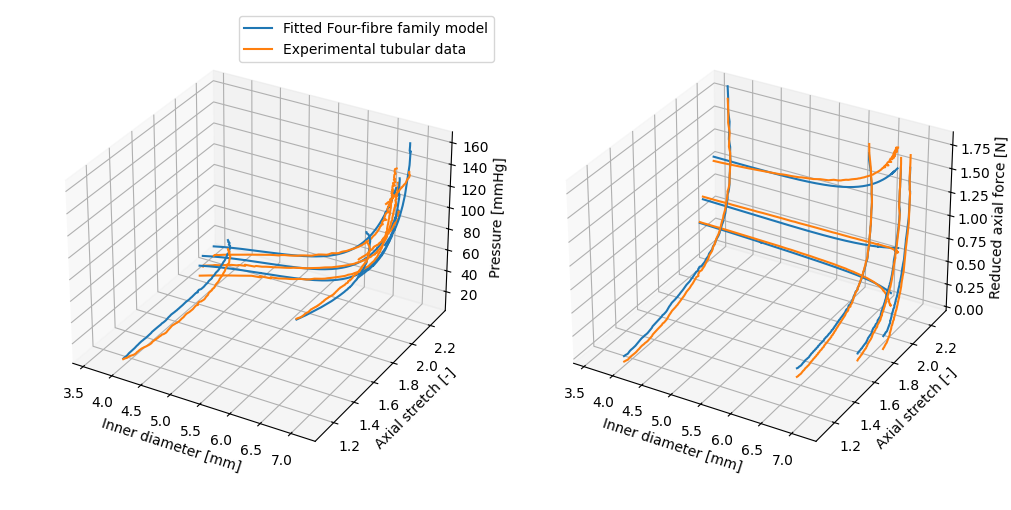

In [23]:
# plotting the fit vs experimental curves
fig, (ax1, ax2) = plt.subplots(
    1,2,
    subplot_kw={"projection": "3d"},
    figsize=(10,10),
    constrained_layout=True
)

first = True
first2 = True

for name, var in dynamax_pd_data.items():

    p_meas = np.asarray(var["pressure"], dtype=float).ravel()
    d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
    d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
    f_meas = np.asarray(var["force"], dtype=float).ravel()
    lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

    stresses = ff_stress(lambda_t, lambda_z_meas,
                    result_ff_dyn[0], result_ff_dyn[1], result_ff_dyn[2],result_ff_dyn[3],
                    result_ff_dyn[4],result_ff_dyn[5],result_ff_dyn[6],result_ff_dyn[7])
    sigma_tt_mod = stresses["sigmatt_total"]
    sigma_zz_mod = stresses["sigmazz_total"]
    sigma_rr_mod = stresses["sigmarr_total"]

    h = H / (lambda_t * lambda_z_meas) # deformed wall thickness
    r_m = D_m/2 * lambda_t # deformed mid-wall radius

    p_model_ff = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
    p_scale = np.mean(p_meas)

    f_mod_ff = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)
    f_scale = np.mean(f_meas)

    if first:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_ff,
                color='C0', label='Fitted Four-fibre family model')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,
                color='C1', label='Experimental tubular data')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_ff,color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,color='C1')
        first = False
    else:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_ff, color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas,  p_meas, color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_ff,color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,color='C1')

    ax1.set_zlabel('Pressure [mmHg]')
    ax1.set_ylabel('Axial stretch [-]')
    ax1.set_xlabel('Inner diameter [mm]')
    ax1.set_box_aspect(None, zoom=0.88)
    ax1.legend()

for name, var in dynamax_fl_data.items():

    p_meas = np.asarray(var["pressure"], dtype=float).ravel()
    d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
    d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
    f_meas = np.asarray(var["force"], dtype=float).ravel()
    lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()
    length_y = length_initial*lambda_z_meas

    stresses = ff_stress(lambda_t, lambda_z_meas,
                    result_ff_dyn[0], result_ff_dyn[1], result_ff_dyn[2],
                    result_ff_dyn[3],result_ff_dyn[4],result_ff_dyn[5],
                    result_ff_dyn[6],result_ff_dyn[7])
    sigma_tt_mod = stresses["sigmatt_total"]
    sigma_zz_mod = stresses["sigmazz_total"]
    sigma_rr_mod = stresses["sigmarr_total"]

    h = H / (lambda_t * lambda_z_meas) # deformed wall thickness
    r_m = D_m/2 * lambda_t # deformed mid-wall radius

    p_model_ff = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
    p_scale = np.mean(p_meas)

    f_mod_ff = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)
    f_scale = np.mean(f_meas)

    if first2:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_ff,color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_mod_ff,color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,color='C1')
        first2 = False
    else:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_ff,color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas,  f_mod_ff, color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas,  f_meas, color='C1')

    ax2.set_ylabel('Axial stretch [-]')
    ax2.set_xlabel('Inner diameter [mm]')
    ax2.set_zlabel('Reduced axial force [N]')
    ax2.set_box_aspect(None, zoom=0.88)


If you take a moment to look back at the HGO fit plots, you’ll see that the four-fibre family model provides a better fit of the tubular data. This highlights an important point: different models offer different degrees of freedom, which allows for capturing data with different levels of complexity, anisotropy, and non-linearity. Choosing a model that matches the complexity of the experimental data is crucial in consitutive modelling.

So far, we’ve fitted the HGO model to both planar biaxial and tubular data, and the four-fibre family model to the tubular data. Now, let’s see how well these models perform in extrapolation — in other words, how well they can predict the response to deformations that were not used for the determination of the model parameters.

We already saw that the four-fibre family model provides a good fit to the tubular data. Next, we’ll test how it predicts planar biaxial behaviour. To do this, we’ll take the four-fibre material parameters obtained from the tubular fit and use them to simulate the tissue response to planar biaxial deformations.

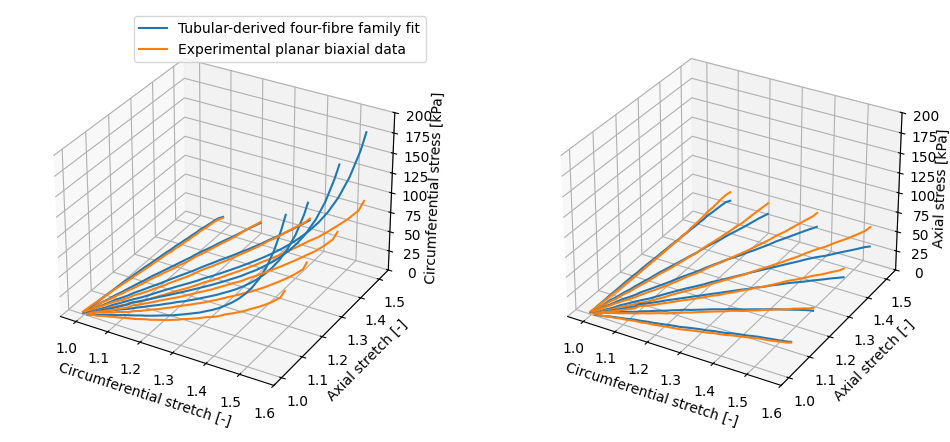

In [24]:
# Assessing the quality of DynamX-based constitutive results in
# capturing planar biaxial tests

fig, (ax1, ax2) = plt.subplots(
    1,2,
    subplot_kw={"projection": "3d"},
    figsize=(12, 12),
    #constrained_layout=True
)
first1 = True
first2 = True

for name, var in biaxial_data.items():
    lambda_t_meas = np.asarray(var["stretch_x"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_y"], dtype=float).ravel()
    sigma_tt_meas = np.asarray(var["cauchy_x"], dtype=float).ravel()
    sigma_zz_meas = np.asarray(var["cauchy_y"], dtype=float).ravel()
    stresses = ff_stress(lambda_t_meas, lambda_z_meas,
                    result_ff_dyn[0], result_ff_dyn[1], result_ff_dyn[2],
                    result_ff_dyn[3],result_ff_dyn[4],result_ff_dyn[5],result_ff_dyn[6],result_ff_dyn[7])
    sigma_tt_mod = stresses["sigmatt_total"] - stresses["sigmarr_total"] # also accounting for the Lagrange multiplier
    sigma_zz_mod = stresses["sigmazz_total"] - stresses["sigmarr_total"] # also accounting for the Lagrange multiplier

    if first1:
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_mod/1000,
                color='C0', label='Tubular-derived four-fibre family fit')
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_meas/1000,
                color='C1', label='Experimental planar biaxial data')
        first1 = False
    else:
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_mod/1000, color='C0')
        ax1.plot(lambda_t_meas, lambda_z_meas, sigma_tt_meas/1000, color='C1')

    if first2:
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_mod/1000,
                color='C0')
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_meas/1000,
                color='C1')
        first2 = False
    else:
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_mod/1000, color='C0')
        ax2.plot(lambda_t_meas, lambda_z_meas, sigma_zz_meas/1000, color='C1')

ax1.set_xlabel('Circumferential stretch [-]')
ax1.set_ylabel('Axial stretch [-]')
ax1.set_zlabel('Circumferential stress [kPa]',labelpad=0.1)
ax1.set_box_aspect(None, zoom=0.9)
ax1.legend()
ax1.set_zlim([0,200])
ax2.set_xlabel('Circumferential stretch [-]')
ax2.set_ylabel('Axial stretch [-]')
ax2.set_zlabel('Axial stress [kPa]',labelpad=0.1)
ax2.set_box_aspect(None, zoom=0.9)
ax2.set_zlim([0,200])

plt.show()


As you can see in the plots above, the four fibre family model parameterised on tubular data captures the planar biaxial response quite well at small deformations. However, at higher deformation, the meodelled response is much more non-linear that that measured experimentally, especially in the circumferential direction.

Now, let’s look at extrapolation in the other direction. We’ll examine how the HGO material parameters obtained from the planar biaxial tests perform when used to simulate tubular behaviour.

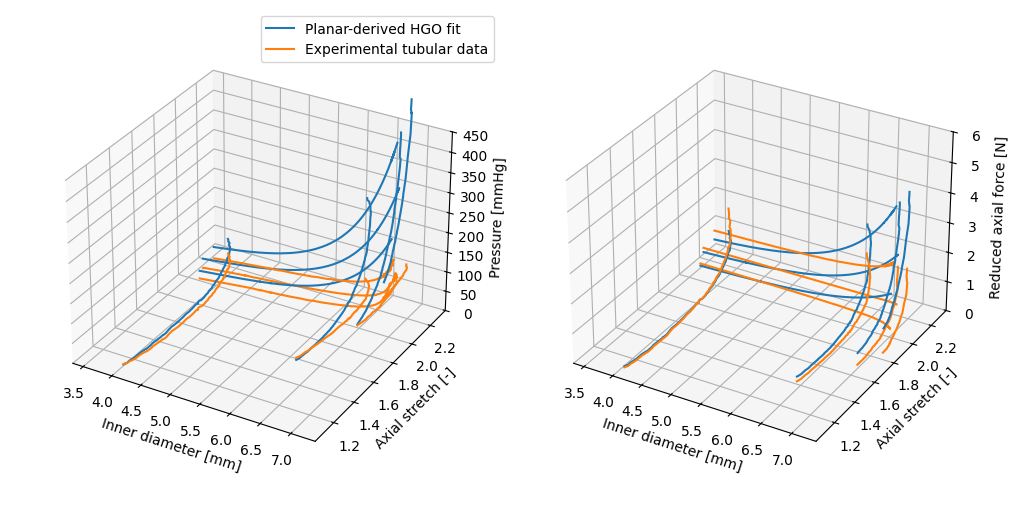

In [25]:
# Assessing the quality of planar-based constitutive results in
# capturing tubular tests

fig, (ax1, ax2) = plt.subplots(
    1,2,
    subplot_kw={"projection": "3d"},
    figsize=(10,10),
    constrained_layout=True
)

first = True
first2 = True

for name, var in dynamax_pd_data.items():

    p_meas = np.asarray(var["pressure"], dtype=float).ravel()
    d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
    d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
    f_meas = np.asarray(var["force"], dtype=float).ravel()
    lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

    stresses = hgo_stress(lambda_t, lambda_z_meas, result_hgo[0] , result_hgo[1], result_hgo[2], result_hgo[3])
    sigma_tt_mod = stresses["sigmatt_total"]
    sigma_zz_mod = stresses["sigmazz_total"]
    sigma_rr_mod = stresses["sigmarr_total"]

    h = H / (lambda_t * lambda_z_meas) # deformed wall thickness
    r_m = D_m/2 * lambda_t # deformed mid-wall radius

    p_model_hgo = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
    f_model_hgo = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)

    if first:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo,
                color='C0', label='Planar-derived HGO fit')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,
                color='C1', label='Experimental tubular data')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_model_hgo,color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,color='C1')
        first = False
    else:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo, color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas,  p_meas, color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_model_hgo,color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,color='C1')
    ax1.set_zlim(0,450)
    ax1.set_zlabel('Pressure [mmHg]')
    ax1.set_ylabel('Axial stretch [-]')
    ax1.set_xlabel('Inner diameter [mm]')
    ax1.set_box_aspect(None, zoom=0.88)
    ax1.legend()

for name, var in dynamax_fl_data.items():

    p_meas = np.asarray(var["pressure"], dtype=float).ravel()
    d_o_meas = np.asarray(var["outer_diam"], dtype=float).ravel()
    d_i_meas = np.asarray(var["inner_diam"], dtype=float).ravel()
    lambda_z_meas = np.asarray(var["stretch_z"], dtype=float).ravel()
    f_meas = np.asarray(var["force"], dtype=float).ravel()
    lambda_t = np.asarray(var["stretch_t"], dtype=float).ravel()

    stresses = hgo_stress(lambda_t, lambda_z_meas, result_hgo[0] , result_hgo[1], result_hgo[2], result_hgo[3])
    sigma_tt_mod = stresses["sigmatt_total"]
    sigma_zz_mod = stresses["sigmazz_total"]
    sigma_rr_mod = stresses["sigmarr_total"]

    h = H / (lambda_t * lambda_z_meas) # deformed wall thickness
    r_m = D_m/2 * lambda_t # deformed mid-wall radius

    p_model_hgo = (sigma_tt_mod - sigma_rr_mod) * h / r_m * Pa2mmHg
    f_model_hgo = np.pi * r_m * h * (2*sigma_zz_mod - sigma_tt_mod - sigma_rr_mod)

    if first2:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo,color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_model_hgo,color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas, f_meas,color='C1')
        first2 = False
    else:
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_model_hgo,color='C0')
        ax1.plot(d_i_meas*1000,lambda_z_meas, p_meas,color='C1')
        ax2.plot(d_i_meas*1000,lambda_z_meas,  f_model_hgo, color='C0')
        ax2.plot(d_i_meas*1000,lambda_z_meas,  f_meas, color='C1')
    ax2.set_zlim(0,6)
    ax2.set_ylabel('Axial stretch [-]')
    ax2.set_xlabel('Inner diameter [mm]')
    ax2.set_zlabel('Reduced axial force [N]')
    ax2.set_box_aspect(None, zoom=0.88)


As you can see in the plot above, the HGO model parameterised on planar equibiaxial data poorly captures the experimentally measured response of the artery to tubular testing across the entire range of tested deformations.

This shows that material parameters derived from different types of experiment don’t always translate well to other loading conditions. This is, therefore, a good reminder to be cautious when extrapolating beyond the loading conditions that were used for model parametrisation, as the resulting simulated behaviours may deviate substantially from true biomechanics of the tissue.

**References:**

[1] van der Bruggen, M.M., Reesink, K.D., Spronck, P.J.M. et al. An integrated set-up for ex vivo characterisation of biaxial murine artery biomechanics under pulsatile conditions. Sci Rep 11, 2671 (2021). https://doi.org/10.1038/s41598-021-81151-5